# Breast Cancer Coimbra Dataset

This work is a series of different classification models to predict Breast cancer. The goal is to predict whether the patient has or not Breast cancer.

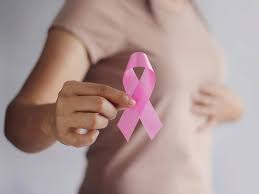

This dataset was provided by **[Patricio, 2018] Patrício, M., Pereira, J., Crisóstomo, J., Matafome, P., Gomes, M., Seiça, R., & Caramelo, F. (2018). Using Resistin, glucose, age and BMI to predict the presence of breast cancer. BMC Cancer, 18(1)** and it's available at https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

def custom_describe(dataset):
    df = dataset.drop(columns=['Classification']).describe().T
    df = df.drop(columns=['count'])
    df['skewness'] = dataset.drop(columns=['Classification']).skew(axis=0).values
    df['maxmin_ratio'] = df['max']/df['min']
    return df

## Loading data and applying pre-processing

In [2]:
dataset = pd.read_csv('dataR2.csv')
dataset.head()

y = dataset['Classification'].replace(1, 0).replace(2, 1).values

In [3]:
df = custom_describe(dataset)
df = df[df.maxmin_ratio > 20]
columns = df.index.values

df = dataset

for item in columns:
    df[item] = power_transform(df[item].values.reshape(-1,1), method='box-cox').reshape(1,-1)[0]
    

df = df.drop(columns=['Classification', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'MCP.1'])

scaler = StandardScaler()
scaler.fit(df)
data = scaler.transform(df)

for i, col in enumerate(df.columns):
    df[col] = data[:,i]

X = df

In [4]:
X.head()

Age       BMI   Glucose  Resistin
0 -0.579794 -0.816675 -1.239222 -0.474352
1  1.601821 -1.378751 -0.258299 -1.609562
2  1.539489 -0.891764 -0.302887 -0.244398
3  0.666843 -1.243303 -0.927110  0.227610
4  1.788816 -1.294601 -0.258299 -0.047058

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Linear models

### Ordinary logistic regression

In [6]:
print("Training...")
start_time = time()
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
end_time = time()
print(f"Training done in {round(end_time - start_time, 3)} seconds\n")

print("Intercept: " + str(clf.intercept_))
print("Coefficients: " + str(clf.coef_))

print("\n# TRAIN PERFORMANCE #")
print(classification_report(y_train, clf.predict(X_train), target_names=['Healthy', 'Patients']))

print("\n# TEST PERFORMANCE #")
print(classification_report(y_test, clf.predict(X_test), target_names=['Healthy', 'Patients']))

Training...
Training done in 0.004 seconds

Intercept: [0.51937286]
Coefficients: [[-0.32812967 -0.56752147  1.58306754  0.55896147]]

# TRAIN PERFORMANCE #
              precision    recall  f1-score   support

     Healthy       0.74      0.70      0.72        37
    Patients       0.79      0.82      0.80        50

    accuracy                           0.77        87
   macro avg       0.77      0.76      0.76        87
weighted avg       0.77      0.77      0.77        87


# TEST PERFORMANCE #
              precision    recall  f1-score   support

     Healthy       0.86      0.80      0.83        15
    Patients       0.80      0.86      0.83        14

    accuracy                           0.83        29
   macro avg       0.83      0.83      0.83        29
weighted avg       0.83      0.83      0.83        29



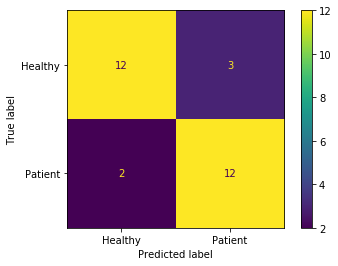

In [7]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Healthy', 'Patient'])

In [8]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

## Non-linear models

### Support Vector Machine (SVM)

In [9]:
print("Training...")
start_time = time()
clf = SVC(C=1.9, kernel='rbf', probability=True).fit(X_train, y_train)
end_time = time()
print(f"Training done in {round(end_time - start_time, 3)} seconds\n")

print("\n# TRAIN PERFORMANCE #")
print(classification_report(y_train, clf.predict(X_train), target_names=['Healthy', 'Patients']))

print("\n# TEST PERFORMANCE #")
print(classification_report(y_test, clf.predict(X_test), target_names=['Healthy', 'Patients']))

Training...
Training done in 0.004 seconds


# TRAIN PERFORMANCE #
              precision    recall  f1-score   support

     Healthy       0.94      0.84      0.89        37
    Patients       0.89      0.96      0.92        50

    accuracy                           0.91        87
   macro avg       0.91      0.90      0.90        87
weighted avg       0.91      0.91      0.91        87


# TEST PERFORMANCE #
              precision    recall  f1-score   support

     Healthy       1.00      0.73      0.85        15
    Patients       0.78      1.00      0.88        14

    accuracy                           0.86        29
   macro avg       0.89      0.87      0.86        29
weighted avg       0.89      0.86      0.86        29



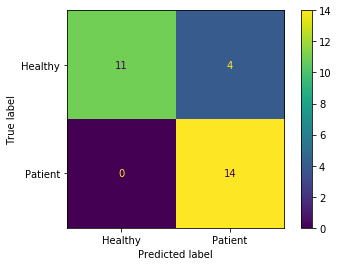

In [10]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Healthy', 'Patient'])

In [11]:
# predict probabilities
svm_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

### Neural Network

In [12]:
print("Training...")
start_time = time()
clf = MLPClassifier(random_state=3, max_iter=1000, 
                    activation='relu', hidden_layer_sizes=(50, 30)).fit(X_train, y_train)
end_time = time()
print(f"Training done in {round(end_time - start_time, 3)} seconds\n")

print("\n# TRAIN PERFORMANCE #")
print(classification_report(y_train, clf.predict(X_train), target_names=['Healthy', 'Patients']))

print("\n# TEST PERFORMANCE #")
print(classification_report(y_test, clf.predict(X_test), target_names=['Healthy', 'Patients']))

Training...
Training done in 0.364 seconds


# TRAIN PERFORMANCE #
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        37
    Patients       1.00      1.00      1.00        50

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87


# TEST PERFORMANCE #
              precision    recall  f1-score   support

     Healthy       1.00      0.80      0.89        15
    Patients       0.82      1.00      0.90        14

    accuracy                           0.90        29
   macro avg       0.91      0.90      0.90        29
weighted avg       0.91      0.90      0.90        29



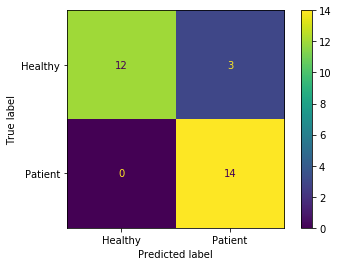

In [13]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Healthy', 'Patient'])

In [14]:
# predict probabilities
nn_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
nn_probs = nn_probs[:, 1]
# calculate scores
nn_auc = roc_auc_score(y_test, nn_probs)
# calculate roc curves
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

## ROC Curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.943
SVM: ROC AUC=0.948
Neural Net: ROC AUC=0.905


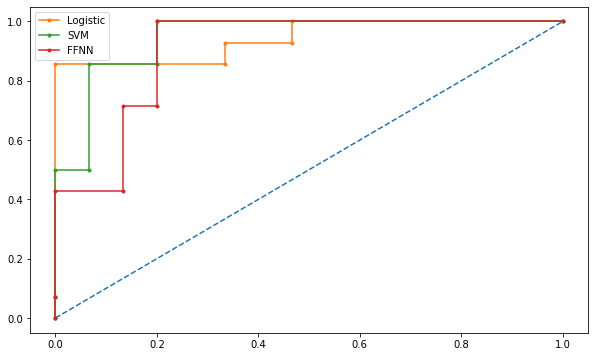

In [16]:
plt.rcParams["figure.figsize"] = (10, 6)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
print('Neural Net: ROC AUC=%.3f' % (nn_auc))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
plt.plot(nn_fpr, nn_tpr, marker='.', label='FFNN')
# show the legend
plt.legend()
# show the plot
plt.show()